# Modifying grids using UETOOLS
This Chapter outlines how to reconverge after making changes to a grid but will, however, not discuss how to generate modified grids, as this functionality is not yet supported by UETOOLS. For more information on grid generation, consult the UEDGE or grid generator documentation. 

Note: it is assumed grids are read from a separate gridue file, as defined by bbb.GridFileName, which is used whenever bbb.gengrid=0. This is the recommended and supported way to use UETOOLS.


## TOC:
* [Modifying the grid shape](#modifying-grid-shape)
* [Modifying the grid dimensions](#modifying-grid-dimensions)
* [Hints for troublesome cases](#hints)

In [1]:
# Restore the case
from os import chdir
chdir('testcase_lores')
from uetools import Case
c = Case('input.yaml') # Create a test at variable "c" from the YAML input file

UEDGE configuration file /Users/holm10/.uetoolsrc read.
Saved solution successfully restored from nc20.hdf5

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 1.54e+00



## Modifying the grid shape<a class="anchor" id="modifying-grid-shape"></a>

If you have a grid with the same dimensions as the intial steady-state file, the grid files can simply be exchanged and the old solution will be read onto the new grid. Alternatively, the variable bbb.GridFileName can be made to point to the new grid. It is recommended to maintain the same number of polodal cells in the inner leg, core region, and outer leg, as well as the radial cells in the private-flux/core region and the main SOL. Changing these variables may result in sufficient deviations from the steady state that the solvers are unable to find a steady-state soution. The mantra "incremental changes" also holds for the grid. 

In UEDGE V8.1.0.0, UETOOLS introduces a function for linearly altering the, effectively morphing it into a new shape. The function Case.gridmorph can be used for this purpose. Case.gridmorph requires that both grids have the same size (e.g. nx and ny), and it is recommended to retain the number of radial and poloidal cells in each region. If cells are morphed between regions around the X-point cut, it is likely that cells may self-intersect as part of their linear displacement between the initial and final grid.


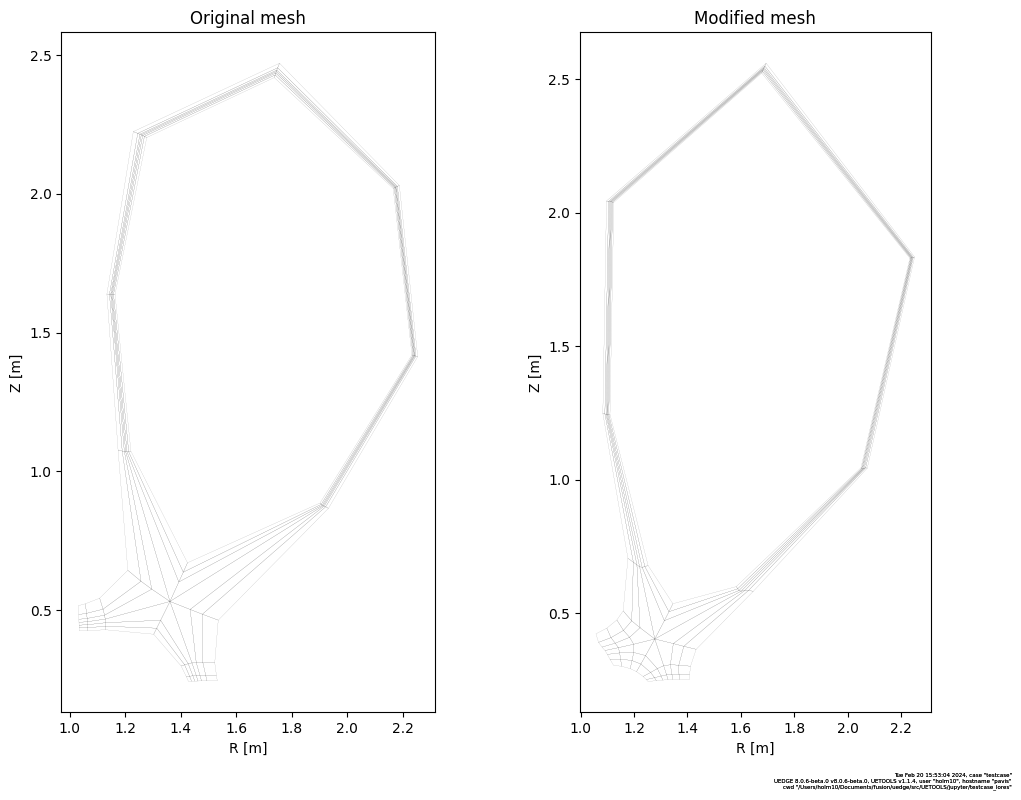

In [2]:
from matplotlib.pyplot import subplots
f, axs = subplots(1,2, figsize=(10,8))
c.grid_hdf5('gridue.hdf5', vessel=False, plates=False, ax=axs[0]);
c.grid_hdf5('gridue_modified.hdf5', vessel=False, plates=False, ax=axs[1]);
axs[0].set_title('Original mesh');
axs[1].set_title('Modified mesh');

In [3]:
isbcwdt=1
c.gridmorph("gridue_modified.hdf5", savedir='gridmorph', dt=1e20)

*----------------------------------------------------------*
 Need to take initial step with Jacobian; trying to do here 
*----------------------------------------------------------*
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             0.000%
    -Advancing by                         0.100%
    -Steps to target at current delta:    1000

 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.7299819846012551E-02 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.4268748149941850E-04 nfe=      9
 iter=    2 fnrm=     0.3580312271429519E-09 nfe=     20


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
===== MAIN LOOP 

Intermediate solution written to gridmorph/progress0p009.hdf5

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 3/7 =====
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             0.920%
    -Advancing by                         0.110%
    -Steps to target at current delta:    900

 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

===== SUCCESS: ADVANCING VARIABLE =====
 iter=    0 fnrm=     0.6861410536801432E-01 nfe=      1
 iter=    1 fnrm=     0.4054345799830096E-01 nfe=     12
 iter=    2 fnrm=     0.2490200845915862E-02 nfe=     23
 iter=    3 fnrm=     0.1673949881998744E-05 nfe=     35
 iter=    4 fnrm=     0.5046735871442183E-10 nfe=     54


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
===== MAIN LOOP 

 iter=    0 fnrm=     0.6302948108236764E-01 nfe=      1
 iter=    1 fnrm=     0.3109245569247913E-04 nfe=      4
 iter=    2 fnrm=     0.5627799549833471E-09 nfe=     10


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./gridmorph/progress0p034_dtrun_last_ii2.hdf5
 Total time = 3.0000E-05; Timestep = 1.0000E-05 

 Inner iteration #4 

Solving for delta=3.360%
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 iter=    0 fnrm=     0.5887727121285003E-01 nfe=      1
 iter=    1 fnrm=     0.3035990831786377E-04 nfe=      4
 iter=    2 fnrm=     0.3393495049727174E-09 nfe=     10


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Inte

 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 iter=    0 fnrm=     0.2265929048770912E-01 nfe=      1
 iter=    1 fnrm=     0.2179301154365617E-04 nfe=      8
 iter=    2 fnrm=     0.1102570181065581E-09 nfe=     23


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./gridmorph/progress0p034_dtrun_last_ii2.hdf5
 Total time = 7.2640E-04; Timestep = 1.1560E-04 

 Inner iteration #5 

Solving for delta=3.360%
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 iter=    0 fnrm=     0.2063413310247731E-01 nfe=      1
 iter=    1 fnrm=     0.1776983352882143E-04 nfe=      8
 iter=    2 fnrm=     0.7840154762314028E-10 nfe=     24


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum

Intermediate solution written to ./gridmorph/progress0p034_dtrun_last_ii2.hdf5
 Total time = 8.6612E-03; Timestep = 1.3363E-03 

 Inner iteration #5 

Solving for delta=3.360%
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 iter=    0 fnrm=     0.2784962232769001E-02 nfe=      1
 iter=    1 fnrm=     0.5061010740631940E-03 nfe=     12
 iter=    2 fnrm=     0.5299206321747538E-07 nfe=     23


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./gridmorph/progress0p034_dtrun_last_ii2.hdf5
 Total time = 9.9975E-03; Timestep = 1.3363E-03 

---------------------------------------------------------------
*** Number of time-step changes = 6 New time-step: 4.54E-03 ***
---------------------------------------------------------------
Solving for delta=3.360%
 TARGE

Intermediate solution written to ./gridmorph/progress0p034_dtrun_last_ii2.hdf5
 Total time = 1.1584E-01; Timestep = 1.5448E-02 

---------------------------------------------------------------
*** Number of time-step changes = 8 New time-step: 5.25E-02 ***
---------------------------------------------------------------
Solving for delta=3.360%
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.1191459582473271E-03 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.6931330084665914E-05 nfe=     13
 iter=    2 fnrm=     0.9541633074601670E-10 nfe=     25


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./gridmorph/progress0p034_dtrun_last_ii2.hdf5
 In

 iter=    0 fnrm=     0.1505234656562566     nfe=      1
 iter=    1 fnrm=     0.5855459605261450E-02 nfe=     13
 iter=    2 fnrm=     0.2733065973738104E-04 nfe=     24
 iter=    3 fnrm=     0.3135646258321376E-09 nfe=     42


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.

===== SUCCESS: ADVANCING VARIABLE =====
 Interpolants created; mype =                   -1
===== MAIN LOOP 7/7 =====
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             3.745%
    -Advancing by                         0.055%
    -Steps to target at current delta:    1750

 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

===== INNER LOOP COMPLETED: ADVANCING DELTA =====
 iter=    0 fnrm=     0.1459006943812648     nfe=      1
 iter=    1 fnrm=     0.4960285500071232E-02 nfe=     13
 iter=    

===== MAIN LOOP 2/7 =====
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             4.913%
    -Advancing by                         0.266%
    -Steps to target at current delta:    357

 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

===== SUCCESS: ADVANCING VARIABLE =====
 iter=    0 fnrm=     0.1392329305158962     nfe=      1
 iter=    1 fnrm=     0.3315438907355591E-01 nfe=      7
 iter=    2 fnrm=     0.3534248836868633E-04 nfe=     11
 iter=    3 fnrm=     0.1987545157052786E-08 nfe=     19


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
===== MAIN LOOP 3/7 =====
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             5.179%
    -Advancing by 

===== MAIN LOOP 5/7 =====
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             8.853%
    -Advancing by                         0.586%
    -Steps to target at current delta:    155

 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

===== SUCCESS: ADVANCING VARIABLE =====
 iter=    0 fnrm=     0.1342428703540170     nfe=      1
 iter=    1 fnrm=     0.5926911560270804E-02 nfe=     10
 iter=    2 fnrm=     0.9600865327580676E-05 nfe=     19
 iter=    3 fnrm=     0.1640503454008794E-08 nfe=     35


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
===== MAIN LOOP 6/7 =====
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             9.439%
    -Advancing by 

Intermediate solution written to gridmorph/progress0p196.hdf5

===== INNER LOOP COMPLETED: ADVANCING DELTA =====
===== MAIN LOOP 1/7 =====
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             19.629%
    -Advancing by                         2.834%
    -Steps to target at current delta:    28

 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

===== SUCCESS: ADVANCING VARIABLE =====  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.8349593447137200E-01 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.4914369321629187E-02 nfe=      6
 iter=    2 fnrm=     0.5561670108487451E-05 nfe=     11
 iter=    3 fnrm=     0.1480294537309985E-10 nfe=     19


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants c


===== SUCCESS: ADVANCING VARIABLE ===== TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.1266102626257373E-04 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.9231568670431879E-10 nfe=     12


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
===== MAIN LOOP 2/7 =====
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             96.840%
    -Advancing by                         13.719%
    -Steps to target at current delta:    0

 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

===== TARGET VALUE ACHIEVED: REDUCE FNORM ====
    -Variable(s) being solved:
                                     



## Modifying the grid dimensions<a class="anchor" id="modifying-grid-dimensions"></a>
Sometimes it is necessary to change the resoltuion or dimensions of a grid. As the change is made, an intial state is required for the new grid resolution, as the old save no longer is commutable into the different-shaped "state" variables. UETOOLS has a function for interpolating solutions for different grids. 

Presently, the interpolation applies a simple linear solution in index-space, as this has been found to be the most effective interpolation scheme. However, additional schemes are available and being worked on, but not presented here.

To create an interpolated solution, you need a grid-solution file pair for the converged case, and a grid file for the new grid:


In [4]:
c.interpolate_snull('gridue.hdf5', '../testcase_hires/gridue.hdf5', 'nc20.hdf5');
!ls -lrt | tail -1

-rw-r--r--   1 holm10  27647  212776 Feb 20 15:44 interpolated_16x8-32x16


The syntax for Case.interpolate_snull is Case.interpolate_snull(\<steady-state-grid-file\>, \<stead-state-save-file\>, \<new-grid-file\>). The function writes a new save file, called "interpolated_\<old-dimensions\>-\<new-dimensions\>". This save-file can then be used as the save-file in a new input file, where reading the corresponding grid, whereafter the case can be reconverged for the new resolution.

**Note:** Presently, interpolation is only available for single-null geometries.

**Note:** only the time-dependent solver can be utilized after interpolating the grid, as such changes are, by nature, discrete

## Hints for troublesome cases<a class="anchor" id="hints"></a>

Generally, making modifications to the grid may make it hard to take an initial time-step using the continuation solver, even at dtreal<1e-10. If such behavior is encountered, the variable bbb.isbcwdt can be set to unity. This variable makes the boundary conditions time-dependent, which relaxes the system of equations. This may, however, result in unstable solutions. 

Any time-dependent runs using bbb.isbcwdt=1 should be interrupted when the initial fnrm starts increasing exponentially and bbb.isbcwdt=0 should be restored before resuming the time-dependent solver. Note that the time-dependent solve for bbb.isbcwdt=0 may require very small (dtreal<1e-10) time-steps.

If issues are still encountered, the potential equation may also be made time-dependent by decreasing the its time-step dtphi. Note that dtphi is increased by the time-dependent solver and, thus, does not need to be reset.